In [6]:
import torch
import torch as nn

# Importamos otras bibliotecas de utilidad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Manejo de ficheros
import os

# Ignoramos los warning
import warnings
warnings.filterwarnings("ignore")

# Importamos OpenCV
import cv2

In [7]:
# Comprobamos la version de PyTorch instalada
print(torch.__version__)

2.0.1


## Conjunto de datos 

Este conjunto de datos tiene su origen en el Instituto de Visión y Gráficos por Computadora de la Universidad Tecnológica de Graz

Obtenido de un reto de Kaggle (https://www.kaggle.com/datasets/santurini/semantic-segmentation-drone-dataset/data). En este dataset vemos dos conjuntos de datos, uno para realizar segmentación binaria y otro para multiclase, este último es de nuestro interés.

Esta compuesto por 5 macrogrupos de clases {obstaculos, agua, naturaleza, en movimiento, aterrizable}

## Carga de datos

In [8]:
from tqdm import tqdm
import time

In [9]:
# Función para cargar y procesar las imágenes
def load_images(path, mask, dim, map_pixels_intermediate, map_pixels_final):
    images = []

    # Recorremos todas las imágenes de la carpeta
    for filename in tqdm(os.listdir(path), desc="Procesando imágenes"):
        
        # Unicamente imágenes en formato png o jpg
        if filename.endswith(".png") or filename.endswith(".jpg"):
            
            # Obtener el número de imagen del nombre de archivo
            image_number = filename.split('.')[0]
            
            # Obtenemos la ruta a la imagen en concreto
            image_path = os.path.join(path, filename)
            
            # Si es máscara, obtenemos la imagen en escala de grises si no, en formato RGB
            if mask is True:
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                
                # Remapeamos los píxeles utilizando el diccionario 
                # Primero aplicamos el mapeo intermedio
                for key, value in map_pixels_intermediate.items():
                     image[image == key] = value

                # Luego aplicamos el mapeo final
                for key, value in map_pixels_final.items():
                     image[image == key] = value
            else:
                image = cv2.imread(image_path) 

            # redimensiona al tamaño elegido
            resized_image = cv2.resize(image, dim)

            # Agregar la imagen a la lista, con su número
            images.append((image_number, resized_image))
    
    # Ordenar la lista por número de imagen para que coincidan las máscaras y las imágenes originales
    images.sort(key=lambda x: int(x[0]))
    
    # Obtenemos únicamente las imágenes de la lista de tuplas, sin los índices
    return [image for (_, image) in images]

### Elegir dimensiones que han de tomar las imágenes de salida

In [10]:
# Para evitar que se superpongan valores de pixeles, primero mapeo los pixeles a valores por encima del valor maximo de la clase
map_pixels_intermediate = {
    0: 24, 6: 24, 10: 24, 11: 24, 12: 24, 13: 24, 14: 24, 21: 24, 22: 24, 23: 24,
    5: 25, 7: 25,
    2: 26, 3: 26, 8: 26, 19:26,20:26,
    15:27,16:27,17:27,18:27,
    1:28,4:28,9:28
}

# Y despues los pixeles mapeados a los valores de clase correspondientes tomando valores de 0 a 4
# 0 --> obstaculos 1 --> agua 2--> vegetacion 3--> movimiento 4-->aterrizable
map_pixels_final = {
    24:0,
    25:1,
    26:2,
    27:3,
    28:4
}

In [11]:
# Booleano que nos diferencia de tratar las mascaras en escala de grises o imagenes originales RGB
# Tamaño al que queremos redimensionar las mascaras e imagenes
is_mask = True
dim = (256,256)

In [12]:
# Rutas de las carpetas que contienen las imágenes

path_mask = "Dataset/semantic_drone_dataset/dataset_equilibrado/label_images_semantic"
path_original_img = "Dataset/semantic_drone_dataset/dataset_equilibrado/original_images"

# Medimos los tiempos para cargar las máscaras
t_ini = time.time()

# Cargar las imágenes de las etiquetas (máscaras) en escala de grises
label_images = load_images(path_mask, is_mask, dim, map_pixels_intermediate, map_pixels_final)

t_fin = time.time()
print("\nEl tiempo de carga de las máscaras es de: ", t_fin-t_ini, " segundos")

# Cargar las imágenes originales en formato RGB
is_mask = False

t_ini = time.time()
original_images = load_images(path_original_img, is_mask, dim, map_pixels_intermediate, map_pixels_final)
t_fin = time.time()

print("\nEl tiempo de carga de las imágenes es de: ", t_fin-t_ini, " segundos")

Procesando imágenes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:36<00:00,  3.48it/s]



El tiempo de carga de las máscaras es de:  36.748104095458984  segundos


Procesando imágenes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:38<00:00,  3.29it/s]


El tiempo de carga de las imágenes es de:  38.91901445388794  segundos


In [13]:
# Para encontrar el valor máximo de las máscaras y comprobamos que es 4, ya que tenemos 5 clases.
# Si el pixel vale:
# 0 --> obstaculo
# 1 --> agua
# 2 --> naturaleza (vegetacion)
# 3 --> objetos en movimiento
# 4 --> zonas aterrizables

max(np.max(mask) for mask in label_images)

4

In [14]:
# Array en el que almacenamos cuantas imagenes tienen al menos 100 pixeles
# En la posicion 0, las imagenes que tienen al menos 100 pixeles de la clase 0 y asi

clases_count = []

for i in range(5):
    # Reinicia el contador en cada iteración de clase
    count = 0 
    for mask in label_images:
        if np.sum(np.array(mask) == i) > 10:
            count += 1
    clases_count.append(count)

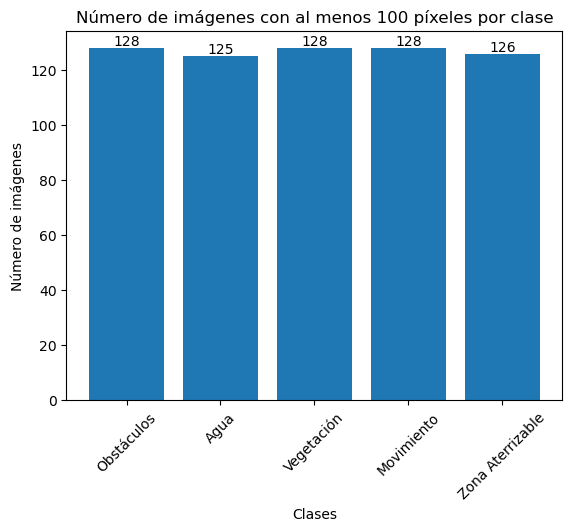

In [15]:
labels = ["Obstáculos", "Agua", "Vegetación", "Movimiento", "Zona Aterrizable"]

plt.bar(labels, clases_count)
plt.xlabel('Clases')
plt.ylabel('Número de imágenes')
plt.title('Número de imágenes con al menos 100 píxeles por clase')
plt.xticks(rotation=45)  # Para que las etiquetas del eje x estén inclinadas

# Añadimos etiqueta
for i, v in enumerate(clases_count):
    plt.text(i, v + 1, str(v), color='black', ha='center')
    
plt.show()

#### Como podemos observar el tiempo de carga de las imágenes RBG ligeramente superior que el de las máscaras, en escala de grises. Podriamos pensar que deberia ser el triple debido a que las imágenes RBG presentan 3 canales de información y las máscaras tan solo 1. Aunque es cierto que esto ocurre, en nuestro caso necesitamos realizar un mapeo del valores de los píxeles, este mapeo realentiza el doble el tiempo de carga de las máscaras.

In [16]:
# Ahora, label_images contiene imágenes en escala de grises 
# y original_images contiene imágenes en formato RGB.

# Accedemos a la quinta imagen como ejemplo
label_image = label_images[6]
original_image = original_images[6]

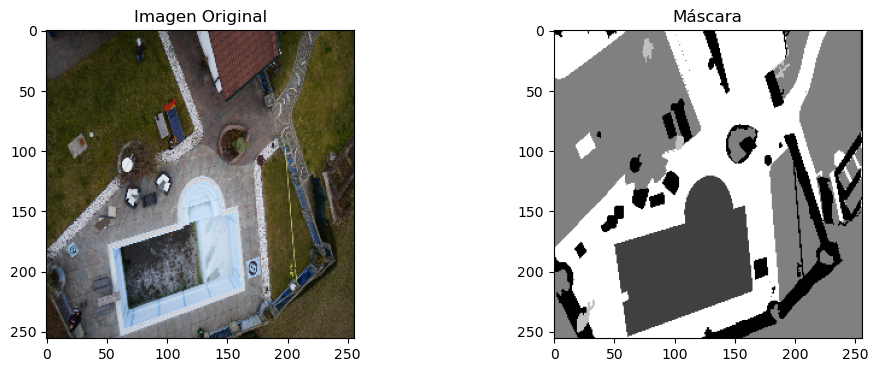

In [17]:
# Aqui realizo una impresión de la máscara en escala de grises y de la imagen original, tomando como ejemplo la imagen 0 el conjunto
# Mostrar la imagen de la máscara (escala de grises)
plt.figure(figsize=(12, 4)) 

# Mostrar la imagen original (RGB)
plt.subplot(121)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Imagen Original")

plt.subplot(122)
plt.imshow(label_image, cmap='gray')
plt.title("Máscara")

plt.show()

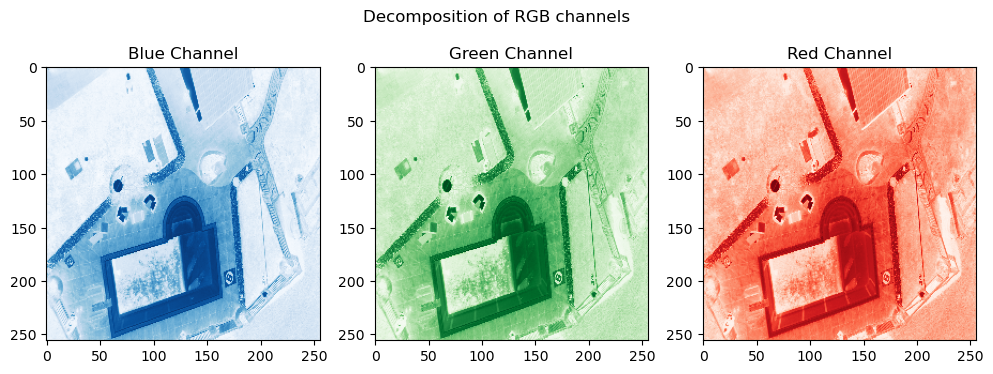

In [18]:
# Extraemos de original_image, las 3 matrices, una por cada canal de informacion

channel_blue = original_image[:,:,0] # blue
channel_green = original_image[:,:,1] # green
channel_red = original_image[:,:,2] # red

# Representamos cada una de ellas
plt.figure(figsize=(12, 4))  # Tamaño de la figura

plt.subplot(131)
plt.imshow(channel_blue, cmap='Blues')
plt.title("Blue Channel")

plt.subplot(132)
plt.imshow(channel_green, cmap='Greens')
plt.title("Green Channel")

plt.subplot(133)
plt.imshow(channel_red, cmap='Reds')
plt.title("Red Channel")

plt.suptitle("Decomposition of RGB channels")  # Título general
plt.show()

## Preprocesamiento de las imágenes

#### Como el conjunto de datos del que disponemos es pequeño vamos a aplicar técnicas de Data Augmentation, para conseguir aumentar la diversidad de las muestras de entrenamiento.

## Técnicas de Data Augmentation

##### Con el fin de aumentar el número de imágenes del conjunto de entrenamiento para el modelo, vamos a realizar transfromaciones como reflejos, rotaciones, cambios de brillo y zoom en este conjunto. Así conseguimos tener más imágenes y aumentar la capacidad de generalización del modelo

In [19]:
import torchvision.transforms as transforms
from torchvision.utils import save_image

# Rotaciones
from scipy.ndimage import rotate

### Efecto espejo

In [20]:
# Conseguimos proporcionar variabilidad en las imágenes y aumentar el tamaño del conjunto de entrenamiento

def mirror_effect(imgs, masks):
    for i in range(len(imgs)):
        imgs.append(np.fliplr(imgs[i]))
        masks.append(np.fliplr(masks[i]))

In [21]:
mirror_effect(original_images, label_images)
len(original_images), len(label_images)

(256, 256)

#### Tras la primera transformación, duplicamos el número de imágenes --> pasamos de tener 400 imagenes y 400 máscaras a 800 de cada una de ellas

In [22]:
max(np.max(mask) for mask in label_images)

4

### Variabilidad de la imagen

In [23]:
def variability_effect(brillo, contraste, saturacion, imagenes, is_mask):
    
    imagenes_modif = []

    # Usar tqdm para mostrar una barra de progreso
    for imagen_original in imagenes:
        if is_mask:
            # No realizamos ninguna transformación
            imagen_ajst = imagen_original
        else:
            # Ajustar el brillo y contraste
            imagen_ajst = cv2.convertScaleAbs(imagen_original, alpha=contraste, beta=brillo)

            # Convertir la imagen a formato HSV
            imagen_hsv = cv2.cvtColor(imagen_ajst, cv2.COLOR_RGB2HSV)

            # Ajustar la saturación
            imagen_hsv[:, :, 1] = imagen_hsv[:, :, 1] * saturacion

            # Convertir la imagen de nuevo a formato RGB
            imagen_ajst = cv2.cvtColor(imagen_hsv, cv2.COLOR_HSV2RGB)

        # Agregar la imagen modificada a la lista de imágenes modificadas
        imagenes_modif.append(imagen_ajst)

    return imagenes_modif


In [24]:
# Parámetros a modificar:
# --> Brillo
# --> Contraste
# --> Saturación

brillo = 1.5
contraste = 1.2
saturacion = 1.5

# Modificamos las imagenes
var_images = variability_effect(brillo, contraste, saturacion, original_images, is_mask)

# Modificamos las máscaras
is_mask = True
var_masks = variability_effect(brillo, contraste, saturacion, label_images, is_mask)

# Las añadimos a los conjuntos de imagenes correspondientes
original_images.extend(var_images)
label_images.extend(var_masks)

In [25]:
len(original_images), len(label_images)

(512, 512)

In [26]:
max(np.max(mask) for mask in label_images)

4

#### Nuevamente duplicamos el número de imágenes y máscaras del conjunto, pasamos de tener 800 en cada una de ellas a 1600.

In [27]:
def rotation_effect(angulos, imagenes, is_mask):
    imagenes_rotadas = []
    
    # Para cada imagen
    for imagen in tqdm(imagenes, desc="Rotando tus imágenes"):
        # Vamos a obtener 7 imágenes por cada una de ellas, puesto que las rotamos de 45º en 45º
        for angulo in angulos:
            
            # La opción reflect, nos completa las esquinas que quedarian en negro tras la rotación
            if is_mask is True:
                # Order=0 para vecino más cercano, y así evitar que se modifiquen ciertos valores de píxeles
                imagen_rotada = rotate(imagen, angulo, reshape=False, mode='reflect', order = 0) 
                imagenes_rotadas.append(imagen_rotada)
            else:
                # Iteracion entre los canales de la imagen
                canales_rotados = [rotate(channel, angulo, reshape=False, mode='reflect') for channel in np.rollaxis(imagen, 2)]
                imagen_rotada = np.stack(canales_rotados, axis=-1)
                imagenes_rotadas.append(imagen_rotada)
            
    return imagenes_rotadas

In [28]:
rotaciones = [45, 90, 135, 180, 225, 270, 315]
#rotaciones = [90, 180, 270]

# Rotaciones para las imagenes RGB
is_mask = False
rot_images = rotation_effect(rotaciones, original_images, is_mask)

# Rotaciones para las máscaras
is_mask = True
rot_masks = rotation_effect(rotaciones, label_images, is_mask)

Rotando tus imágenes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 78.39it/s]


In [29]:
# Las añadimos a los conjuntos de imagenes correspondientes
original_images.extend(rot_images)
label_images.extend(rot_masks)

del var_images, var_masks#, rot_images, rot_masks

In [30]:
len(original_images), len(label_images)

(4096, 4096)

#### Tras aplicar 7 rotaciones en ángulos diferentes para cada una de las imágenes y máscaras del conjunto de datos anterior, multiplicando por 7 el tamaño del conjunto. De esta forma conseguimos tener 12800 imágenes, y dotamos al modelo de un mayor conjunto de datos para poder aprender y generalizar.

In [31]:
max(np.max(mask) for mask in label_images)

4

## Mostramos las imágenes RGB modificadas

### Aunque no se haya mostrado, a su vez cada imagen espejo, variada y variada espejo, presenta tambien sus 7 rotaciones en los diferentes ángulos. Considero importante mencionarlo de ahí que se obtengan 12000 imágenes pero únicamente muestro las rotaciones de la imagen original, para evitar complicaciones

## Mostramos las máscaras modificadas

## Conjunto de entrenamiento y prueba

##### Para separar las imágenes de train y test, vamos a randomizar con una semilla el orden de las imágenes y las máscaras. Así conseguimos que al aplicar un hold-out para separar generar cada conjunto, las imágenes que van a cada conjunto sean random, y no por orden de aparición en el conjunto.

In [32]:
# Imports correspondientes

# Separación entre entrenamiento y test
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from multiprocessing import Pool

In [33]:
# Medimos los tiempos para convertir las máscaras
t_ini = time.time()

# Convertimos la tupla de mascaras a tensores
label_images = torch.Tensor(label_images)

t_fin = time.time()
print("\nEl tiempo de convertir las máscaras de numpy a tensor es de: ", t_fin-t_ini, " segundos")
print("El tensor de las máscaras tiene tamaño: ", label_images.shape)


El tiempo de convertir las máscaras de numpy a tensor es de:  23.316162109375  segundos
El tensor de las máscaras tiene tamaño:  torch.Size([4096, 256, 256])


In [34]:
# Medimos los tiempos para convertir las máscaras
t_ini = time.time()

# Convertimos la tupla de mascaras a tensores
original_images = torch.Tensor(original_images)

t_fin = time.time()

print("\nEl tiempo de convertir las imágenes de numpy a tensor es de: ", t_fin-t_ini, " segundos")
print("El tensor de las imágenes tiene tamaño: ", original_images.shape)


El tiempo de convertir las imágenes de numpy a tensor es de:  294.6167182922363  segundos
El tensor de las imágenes tiene tamaño:  torch.Size([4096, 256, 256, 3])


In [35]:
# Generamos los conjuntos de train y test, para imagenes y máscaras usando el 20% para test y el 80% para train

img_train, img_test, labels_train, labels_test = train_test_split(original_images, label_images, test_size=0.2, random_state=42)

In [36]:
# Generamos los datasets de train y test

train_dataset = TensorDataset(img_train, labels_train)
test_dataset = TensorDataset(img_test, labels_test)

# Debido al hold-out aplicado ahora tenemos 320 imagenes para test y 1280 para train

print("\nTamaño del conjunto de train: ", len(train_dataset))
print("\nTamaño del conjunto de test: ", len(test_dataset))


Tamaño del conjunto de train:  3276

Tamaño del conjunto de test:  820


In [37]:
# Empleamos lotes de 6 imágenes

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [38]:
# Despues de hacer lotes de batch imágenes

print("\nHay ", len(train_dataloader), " lotes de ", batch_size," imágenes, formando asi las 1280 imágenes totales usadas para train")
print("\nHay ", len(test_dataloader), " lotes de ", batch_size," imágenes, formando asi las 320 imágenes totales usadas para test")


Hay  205  lotes de  16  imágenes, formando asi las 1280 imágenes totales usadas para train

Hay  52  lotes de  16  imágenes, formando asi las 320 imágenes totales usadas para test


## Normalización ???

## Creación del modelo

In [39]:
# Runneamos en este .ipynb el notebook que contiene la clase del modelo UNet que queremos crear
%run notebooks/Model/unet.ipynb

In [40]:
# Nº clases de salida son 5 los objetos a identificar: agua, vegetacion, obstaculo, movimiento y zona aterrizable
out_classes = 5

# Elección técnica de upsampling
# "conv_transpose" --> convolución transpuesta
# "bilinear" --> interpolación bilineal
# "maxunpooling" --> max unpooling

# unica que he probado
upsample_tec = "bilinear"

# U-NET Model build
unet_model = UNet(out_classes,upsample_tec)

In [41]:
# Comprobamos si nos identifica una GPU --> si la hay lo asignamos a la variable "device"

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device,"\n")

# Pasamos el modelo a la GPU, si disponemos de ella
unet_model #.to(device)

cpu 



UNet(
  (down_1): DownsamplingBlock(
    (blockConv): BlockConv(
      (blockConv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (down_sample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_2): DownsamplingBlock(
    (blockConv): BlockConv(
      (blockConv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv

## Entrenamiento

In [42]:
# Paquete de optimizadores
import torch.optim as optim

from sklearn.metrics import accuracy_score

### Función que lleva a cabo el entrenamiento del modelo. Tiene 5 parámetros, el primero que recibe el modelo creado a partir de su clase, train_dataloader que es el conjunto de entrenamiento, optm representa el optimizador que emplea el modelo, loss_criterion función de pérdida que emplea el entrenamiento y por último, device que contiene la gpu en caso de haberla.

In [43]:
def train_unet(model, train_dataloader, optm, loss_criterion, device, weights=None):
    
    # Modo de entrenamiento del modelo
    model.train()
    losses_epoch = []
    
    # Si se proporcionan pesos, crea una nueva función de pérdida con estos pesos
    if weights is not None:
        loss_criterion = torch.nn.CrossEntropyLoss(weight=weights.to(device))
    
    # Para cada imagen y mascara del conjunto
    for images, masks in train_dataloader:
        
        # Transpone las dimensiones para que los canales estén en la posición correcta
        images = images.permute(0, 3, 1, 2)  

        # Convertimos a long el tensor de las máscaras
        masks = masks.to(torch.long)
        
        # Realiza la inferencia
        outputs = model(images)
        
        # Calcula la pérdida
        loss = loss_criterion(outputs, masks)
        
        # Limpia los gradientes del optimizador
        optm.zero_grad()
        
        # Realiza la retropropagación y actualiza los pesos del modelo
        loss.backward()
        optm.step()
        
        # Liberamos memoria
        del images, masks
        
        losses_epoch.append(loss.item())
    
    return losses_epoch


In [44]:
def validate_unet(model, test_dataloader, criterion, device):
    model.eval()  # Establece el modelo en modo de evaluación
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, masks in test_dataloader:
            
            # Transpone las dimensiones para que los canales estén en la posición correcta, con respecto al modelo [6,3,128,128]
            images = images.permute(0, 3, 1, 2).to(device)
            
            #  Obtiene la salida del modelo
            outputs = model(images)
            
            # Calcula las predicciones
            predictions = torch.argmax(outputs, dim=1)
            
            # Calcula la cantidad de predicciones correctas y el total de muestras
            correct += torch.sum(predictions == masks.to(device)).item()
            total += masks.numel()  # Calcula el número total de píxeles en las máscaras
            
    model.train()  # Devuelve el modelo al modo de entrenamiento
    
    accuracy = (correct / total) * 100.0
    
    return accuracy

In [ ]:
# Definimos parámetros
epochs = 40  # Nº épocas
stop = 9     # Nº iteraciones sin mejora para que pare
epoch_worst = 0       # Contador de epocas sin mejoras

# Función de perdida
floss = 0

# Optimizador
optm = optim.Adam(unet_model.parameters(), lr=0.001)

best_acc_val = 0


# Función de pérdida
# floss = 0 --> Entropía cruzada
# floss = 1 --> Error cuadratico medio

if floss == 0:
    loss_crit = nn.CrossEntropyLoss()
elif floss == 1:
    loss_crit = nn.MSELoss()
    
train_accs = []
test_accs = [] 

t_ini = time.time()

weights = torch.tensor([1.0, 10.0, 1.0, 1.0, 1.0])  # Aumenta el peso de la clase 1

for epoch in range(epochs):
    
    # Precision entrenamiento de la epoca
    train_loss = train_unet(unet_model, train_dataloader, optm, loss_crit, device=device, weights=weights)
    train_acc = 1 -(sum(train_loss) / len(train_loss))
    train_accs.append(train_acc)
    print(f"Época {epoch + 1}, Precisión entrenamiento: {train_acc:.4f}")

    # Precisión validación
    test_acc = validate_unet(unet_model, test_dataloader, loss_crit, device)
    test_accs.append(test_acc)
    print(f"Época {epoch + 1}, Precisión validación: {test_acc:.4f}")
    
    # Control de parada
    if test_acc > best_acc_val :
        best_acc_val = test_acc
        epoch_worst = 0
        torch.save(unet_model, "equilibrado_model.pth")
        print(" ~ GUARDANDO MODELO ~ Obtenemos un test_acc = ", test_acc," %.")
    else:
        epoch_worst += 1
        
    
    if epoch_worst > stop:
        print(" ~~ DETENCIÓN DEL ENTRENAMIENTO ~~ Van ", epoch_worst, " épocas sin obtener mejora.")
    
t_fin = time.time()
print("\nEl tiempo de entrenamiento del modelo son: ", (t_fin-t_ini)/60, " minutos")

## Evolución de la accuracy durante el entrenamiento

In [ ]:
# Número de épocas
epocas = range(1, epochs+1)

test_accs = [elemento / 100 for elemento in test_accs]
    
# Crear el gráfico
plt.figure(figsize=(8, 4))
plt.plot(epocas, train_accs, label='Acc Entrenamiento', marker='x', linestyle='-', color="#FFA500")
plt.plot(epocas, test_accs, label='Acc Validación', marker='x', linestyle='-', color="#32CD32")

# Etiquetas y título
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.title('Evolución Acc en Train y Test')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [ ]:
# Establece el modelo en modo de evaluación
unet_model.eval()

# Como el modelo ya está entrenado y queremos probar con el conjunto de test, no calcula los gradientes de los tensores
with torch.no_grad():
    # Iteramos sobre las imagenes de test
    for batch_idx, (images, _) in enumerate(test_dataloader):
        
        if batch_idx == 1:
            break
            
        # Transpone las dimensiones para que los canales estén en la posición correcta
        images = images.permute(0, 3, 1, 2)

        # Realiza la inferencia
        outputs = unet_model(images)

        # Aplica el umbral de 0.95 a cada máscara de salida
        threshold = 0.999
        # Obtenemos asi máscaras binarias, donde si el pixel supera el umbral de 0.9999 de pertenecer a la clase, le asigna el valor 1, sino 0
        bin_outputs = (outputs > threshold).type(torch.uint8)

        # Defino el grid que contiene el lote de imagenes, que va a tener 6 columnas, y tantas filas como imagenes tenga el lote
        fig, axis = plt.subplots(images.size(0), 6, figsize=(15, images.size(0)*5))

        # Itera sobre las imágenes del lote
        for i in range(images.size(0)):
            
            # Adaptamos la imagen para que pueda ser pintada
            image_numpy = images[i].permute(1, 2, 0)
            image_numpy = image_numpy.numpy().astype('uint8')

            # Visualiza la imagen original
            axis[i, 0].imshow(image_numpy)
            axis[i, 0].set_title(f'Imagen Original - Lote {batch_idx + 1}, Imagen {i + 1}')
            axis[i, 0].axis("off")

            # Visualiza las máscaras de las 5 clases
            for class_idx in range(5):  
                
                # Obtén la máscara binaria de la clase actual
                class_mask = bin_outputs[i, class_idx]

                # Convierte a NumPy
                mask = class_mask.cpu().numpy()

                # Creo una mascara en blanco, del mismo tamaño que la mascara, y de 3 canales, de esta forma podremos pintar la máscara de los colores especificos
                colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
                
                # Si el pixel vale 1, es decir, pertenece a la clase, asignamos los valores RGB correspondientes.
                # Ahi esta class_idx que asigna un color u otro depende de la máscara
                colored_mask[mask == 1] = [(155, 38, 182), (14, 135, 204), (124, 252, 0), (255, 20, 147), (169, 169, 169)][class_idx]

                # Visualiza la máscara coloreada en la cuadrícula correspondiente
                axis[i, class_idx + 1].imshow(colored_mask)
                axis[i, class_idx + 1].axis("off")
                axis[i, class_idx + 1].set_title(f'Máscara Clase {class_idx}')

        plt.tight_layout()
        plt.show()

In [ ]:
# Establece el modelo en modo de evaluación
unet_model.eval()

# Como el modelo ya está entrenado y queremos probar con el conjunto de test, no calcula los gradientes de los tensores
with torch.no_grad():
    # Iteramos sobre las imagenes de test
    for batch_idx, (images, _) in enumerate(test_dataloader):
        
        if batch_idx == 1:
            break
            
        # Transpone las dimensiones para que los canales estén en la posición correcta
        images = images.permute(0, 3, 1, 2)

        # Realiza la inferencia
        outputs = unet_model(images)

        # Aplica el umbral de 0.9999 a cada máscara de salida
        threshold = 0.96
        # Obtenemos asi máscaras binarias, donde si el pixel supera el umbral de 0.9999 de pertenecer a la clase, le asigna el valor 1, sino 0
        bin_outputs = (outputs > threshold).type(torch.uint8)

        # Defino el grid que contiene el lote de imagenes, que va a tener 2 columnas, y tantas filas como imagenes
        fig, axis = plt.subplots(images.size(0), 2, figsize=(10, images.size(0)*5))

        # Itera sobre las imágenes del lote
        for i in range(images.size(0)):
            
            # Adaptamos la imagen para que pueda ser pintada
            image_numpy = images[i].permute(1, 2, 0)
            image_numpy = image_numpy.numpy().astype('uint8')

            # Visualiza la imagen original
            axis[i, 0].imshow(image_numpy)
            axis[i, 0].set_title(f'Imagen Original - Lote {batch_idx + 1}, Imagen {i + 1}')
            axis[i, 0].axis("off")

            # Creo una mascara en blanco del mismo tamaño que la mascara y con tres canales para poder pintarla con colores RGB
            combined_mask = np.zeros((image_numpy.shape[0], image_numpy.shape[1], 3), dtype=np.uint8)

            # Defino los colores para cada clase en orden de prioridad
            colors = [(155, 38, 182), (14, 135, 204), (124, 252, 0), (255, 20, 147), (169, 169, 169)]

            # Visualiza las máscaras de las clases en orden especifico de prioridad
            for class_idx in [4, 1, 2, 3, 0]:   
                
                # Obtén la máscara binaria de la clase actual
                class_mask = bin_outputs[i, class_idx]

                # Convierte a NumPy
                mask = class_mask.cpu().numpy()

                # Si el pixel vale 1 (pertenece a la clase), asignamos los valores RGB correspondientes.
                combined_mask[mask == 1] = colors[class_idx]

            # Visualiza la máscara combinada en la cuadrícula correspondiente
            axis[i, 1].imshow(combined_mask)
            axis[i, 1].axis("off")
            axis[i, 1].set_title(f'Máscara Combinada')

        plt.tight_layout()
        plt.show()

In [4]:
modelo_prueba = torch.load('prueba_agua.pth')

In [ ]:
# Establece el modelo en modo de evaluación
modelo_prueba.eval()

# Como el modelo ya está entrenado y queremos probar con el conjunto de test, no calcula los gradientes de los tensores
with torch.no_grad():
    # Iteramos sobre las imagenes de test
    for batch_idx, (images, _) in enumerate(test_dataloader):
        
        if batch_idx == 1:
            break
            
        # Transpone las dimensiones para que los canales estén en la posición correcta
        images = images.permute(0, 3, 1, 2)

        # Realiza la inferencia
        outputs = modelo_prueba(images)

        # Aplica el umbral de 0.95 a cada máscara de salida
        threshold = 0.96
        # Obtenemos asi máscaras binarias, donde si el pixel supera el umbral de 0.9999 de pertenecer a la clase, le asigna el valor 1, sino 0
        bin_outputs = (outputs > threshold).type(torch.uint8)

        # Defino el grid que contiene el lote de imagenes, que va a tener 6 columnas, y tantas filas como imagenes tenga el lote
        fig, axis = plt.subplots(images.size(0), 6, figsize=(15, images.size(0)*5))

        # Itera sobre las imágenes del lote
        for i in range(images.size(0)):
            
            # Adaptamos la imagen para que pueda ser pintada
            image_numpy = images[i].permute(1, 2, 0)
            image_numpy = image_numpy.numpy().astype('uint8')

            # Visualiza la imagen original
            axis[i, 0].imshow(image_numpy)
            axis[i, 0].set_title(f'Imagen Original - Lote {batch_idx + 1}, Imagen {i + 1}')
            axis[i, 0].axis("off")

            # Visualiza las máscaras de las 5 clases
            for class_idx in range(5):  
                
                # Obtén la máscara binaria de la clase actual
                class_mask = bin_outputs[i, class_idx]

                # Convierte a NumPy
                mask = class_mask.cpu().numpy()

                # Creo una mascara en blanco, del mismo tamaño que la mascara, y de 3 canales, de esta forma podremos pintar la máscara de los colores especificos
                colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
                
                # Si el pixel vale 1, es decir, pertenece a la clase, asignamos los valores RGB correspondientes.
                # Ahi esta class_idx que asigna un color u otro depende de la máscara
                colored_mask[mask == 1] = [(155, 38, 182), (14, 135, 204), (124, 252, 0), (255, 20, 147), (169, 169, 169)][class_idx]

                # Visualiza la máscara coloreada en la cuadrícula correspondiente
                axis[i, class_idx + 1].imshow(colored_mask)
                axis[i, class_idx + 1].axis("off")
                axis[i, class_idx + 1].set_title(f'Máscara Clase {class_idx}')

        plt.tight_layout()
        plt.show()

In [ ]:
# Establece el modelo en modo de evaluación
unet_model.eval()

# Como el modelo ya está entrenado y queremos probar con el conjunto de test, no calcula los gradientes de los tensores
with torch.no_grad():
    # Iteramos sobre las imagenes de test
    for batch_idx, (images, _) in enumerate(test_dataloader):
        
        if batch_idx == 4:
            break
            
        # Transpone las dimensiones para que los canales estén en la posición correcta
        images = images.permute(0, 3, 1, 2)

        # Realiza la inferencia
        outputs = unet_model(images)

        # Aplica el umbral de 0.9999 a cada máscara de salida
        threshold = 0.96
        # Obtenemos asi máscaras binarias, donde si el pixel supera el umbral de 0.9999 de pertenecer a la clase, le asigna el valor 1, sino 0
        bin_outputs = (outputs > threshold).type(torch.uint8)

        # Defino el grid que contiene el lote de imagenes, que va a tener 2 columnas, y tantas filas como imagenes
        fig, axis = plt.subplots(images.size(0), 2, figsize=(10, images.size(0)*5))

        # Itera sobre las imágenes del lote
        for i in range(images.size(0)):
            
            # Adaptamos la imagen para que pueda ser pintada
            image_numpy = images[i].permute(1, 2, 0)
            image_numpy = image_numpy.numpy().astype('uint8')

            # Visualiza la imagen original
            axis[i, 0].imshow(image_numpy)
            axis[i, 0].set_title(f'Imagen Original - Lote {batch_idx + 1}, Imagen {i + 1}')
            axis[i, 0].axis("off")

            # Creo una mascara en blanco del mismo tamaño que la mascara y con tres canales para poder pintarla con colores RGB
            combined_mask = np.zeros((image_numpy.shape[0], image_numpy.shape[1], 3), dtype=np.uint8)

            # Defino los colores para cada clase en orden de prioridad
            colors = [(155, 38, 182), (14, 135, 204), (124, 252, 0), (255, 20, 147), (169, 169, 169)]

            # Visualiza las máscaras de las clases en orden especifico de prioridad
            for class_idx in [4, 1, 2, 3, 0]:   
                
                # Obtén la máscara binaria de la clase actual
                class_mask = bin_outputs[i, class_idx]

                # Convierte a NumPy
                mask = class_mask.cpu().numpy()

                # Si el pixel vale 1 (pertenece a la clase), asignamos los valores RGB correspondientes.
                combined_mask[mask == 1] = colors[class_idx]

            # Visualiza la máscara combinada en la cuadrícula correspondiente
            axis[i, 1].imshow(combined_mask)
            axis[i, 1].axis("off")
            axis[i, 1].set_title(f'Máscara Combinada')

        plt.tight_layout()
        plt.show()